In [103]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [82]:
batch_size = 32
img_height = 224
img_width = 224
DATA_DIR = "../chest_Xray/"
TEST = "test/"
TRAIN = "train/"
VAL = "val/"
NORMAL = "NORMAL"
PNEUMONIA = "PNEUMONIA"
NET = "NET"

In [83]:
# Créer un ensemble de données

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR +  TRAIN,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR + VAL,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 17 files belonging to 2 classes.
Using 3 files for validation.


In [84]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['NORMAL', 'PNEUMONIA']


In [85]:
# Configurer l'ensemble de données pour les performances

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [86]:
# Standardiser les données

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [87]:
# Augmentation des données

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [88]:
# cree le modele

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [89]:
# Compiler le modèle

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:
# Résumé du modèle

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                 

In [91]:
# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint("saved_model.model.h5", monitor='val_loss', verbose=1, save_best_only=True, min_delta = .002)

In [92]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [93]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=10)

In [94]:
# Former le modèle
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/50
131/131 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.7484
Epoch 1: val_loss improved from inf to 0.46212, saving model to saved_model.model.h5
131/131 [==============================] - 45s 335ms/step - loss: 0.5957 - accuracy: 0.7484 - val_loss: 0.4621 - val_accuracy: 0.6667
Epoch 2/50
131/131 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.8665
Epoch 2: val_loss improved from 0.46212 to 0.27777, saving model to saved_model.model.h5
131/131 [==============================] - 45s 345ms/step - loss: 0.3126 - accuracy: 0.8665 - val_loss: 0.2778 - val_accuracy: 1.0000
Epoch 3/50
131/131 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8905
Epoch 3: val_loss did not improve from 0.27777
131/131 [==============================] - 46s 350ms/step - loss: 0.2620 - accuracy: 0.8905 - val_loss: 0.3703 - val_accuracy: 0.6667
Epoch 4/50
131/131 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 

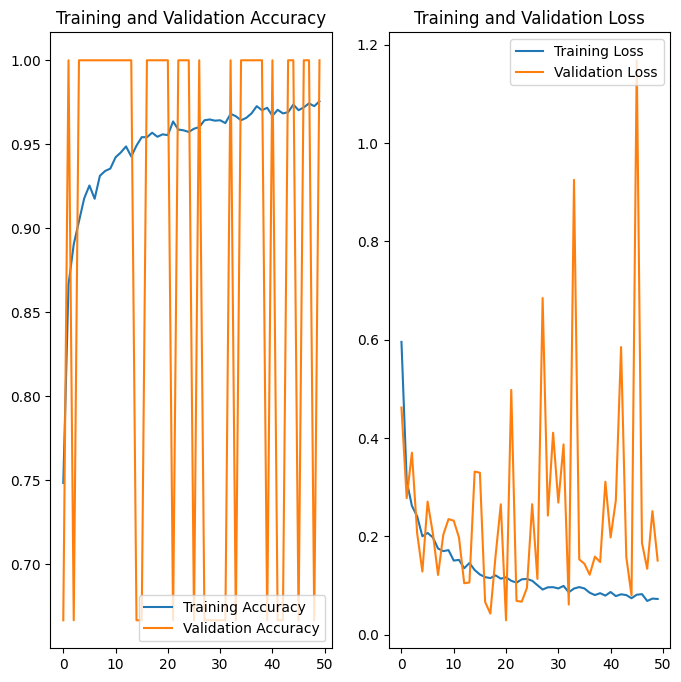

In [95]:
# Visualisez les résultats de l'entraînement

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
# test 
import os
  
  
for file in os.listdir(DATA_DIR + VAL + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  
for file in os.listdir(DATA_DIR + VAL + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + NORMAL + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 0s 54ms/step
This image most likely belongs to PNEUMONIA with a 99.99 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to PNEUMONIA with a 99.95 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to PNEUMONIA with a 99.64 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to PNEUMONIA with a 99.35 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to PNEUMONIA with a 99.68 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to PNEUMONIA with a 99.32 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to PNEUMONIA with a 92.84 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to PNEUMONIA w

In [99]:
from sklearn.metrics import confusion_matrix

val_images = []
val_labels = []
pred_labels = []

for file in os.listdir(DATA_DIR + TEST + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(1)  # pneumonia
  pred_labels.append(np.argmax(score))

for file in os.listdir(DATA_DIR + TEST + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + NORMAL + "/" +file, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(0)  # normal
  pred_labels.append(np.argmax(score))

conf_mat = confusion_matrix(val_labels, pred_labels)
print(conf_mat)

1/1 [==============================] - 0s 18ms/step
[[121 113]
 [  3 387]]


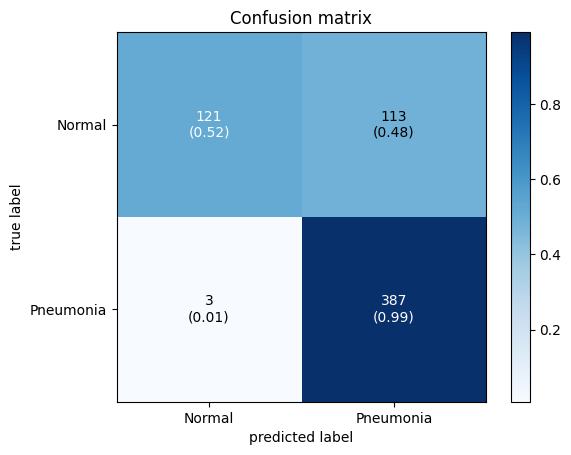

In [104]:
# Get the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)

plt.show()